In this notebook, we will optimize our model's hyperparameters using Keras to find their optimal values. As in our previous notebooks, we'll use the `tf_flowers` dataset.

Let's start by importing the required libraries and retrieving our dataset.

In [1]:
import keras
from keras import layers
import tensorflow_datasets as tfds

In [2]:
dataset = tfds.load('tf_flowers', split=['train'], as_supervised=True)[0]
print("Number of samples in dataset:", dataset.cardinality().numpy())

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of samples in dataset: 3670


Next, we split the dataset into training, validation and test sets (70-15-15).

In [3]:
train_ds = dataset.take(2569)
remaining_ds = dataset.skip(2569)
val_ds = remaining_ds.take(550)
test_ds = remaining_ds.skip(550)
print("Number of samples in training set:", train_ds.cardinality().numpy())
print("Number of samples in validation set:", val_ds.cardinality().numpy())
print("Number of samples in test set:", test_ds.cardinality().numpy())

Number of samples in training set: 2569
Number of samples in validation set: 550
Number of samples in test set: 551


Let's apply data augmentation layers on our training set.

In [4]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(height_factor=0.4),
    layers.RandomBrightness(factor=0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [5]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Now, we resize the images to 180x180 pixels and create batches of 64 images.

In [6]:
train_ds = train_ds.map(lambda x, y: (layers.Resizing(180,180)(x), y))
val_ds = val_ds.map(lambda x, y: (layers.Resizing(180,180)(x), y))
test_ds = test_ds.map(lambda x, y: (layers.Resizing(180,180)(x), y))

In [7]:
train_ds = train_ds.batch(64)
val_ds = val_ds.batch(64)
test_ds = test_ds.batch(64)

In this notebook, we will experiment with learning rates of 1e-3 and 1e-4. In practice, you may need to try random learning rates within a range.

Since our training process involves randomness, each call to `model.fit` may converge at different epochs. To address this variability, we will train the models for a fixed duration of 15 epochs and select the model with the highest validation accuracy. We will use `keras.callbacks.ModelCheckpoint` with `monitor="val_sparse_categorical_accuracy"` to save the model achieving the highest accuracy on the validation set.

#### LEARNING RATE = 1e-3

We create our model using the `Sequential` class from `Keras`. It consists of four convolutional layers, each followed by a max-pooling layer. The output from the convolutional layers is flattened and passed to a fully connected layer with a softmax activation function for class prediction. (same architecture as previous notebook)

In [8]:
model_1 = keras.Sequential()

model_1.add(keras.Input(shape=(180,180,3)))

model_1.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_1.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_1.add(layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_1.add(layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(units=5, activation="softmax"))

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │         103,685 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,101 (4.35 MB)

 Trainable params: 1,140,101 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

We compile our model using `sparse_categorical_crossentropy` loss and `sparse_categorical_accuracy` metric because our labels are encoded as integers. We train the model for 15 epochs using the `adam` optimizer with `learning_rate=1e-3`.

_Note: Use categorical_crossentropy as the loss when your labels are one-hot encoded._

In [9]:
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["sparse_categorical_accuracy"])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "model_1.keras",
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
)

history = model_1.fit(train_ds, epochs=15, callbacks=[model_checkpoint_callback], validation_data=val_ds)

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - loss: 32.0815 - sparse_categorical_accuracy: 0.2240 - val_loss: 1.5324 - val_sparse_categorical_accuracy: 0.2727
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - loss: 1.4833 - sparse_categorical_accuracy: 0.3021 - val_loss: 1.2760 - val_sparse_categorical_accuracy: 0.4709
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 1.2370 - sparse_categorical_accuracy: 0.4718 - val_loss: 1.2973 - val_sparse_categorical_accuracy: 0.5236
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - loss: 1.2086 - sparse_categorical_accuracy: 0.5161 - val_loss: 1.1151 - val_sparse_categorical_accuracy: 0.5527
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 1.1313 - sparse_categorical_accuracy: 0.5518 - val_loss: 1.1593 - val_sparse_categorical_accuracy: 0.5927
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 1.0539 - sparse_categorical_accuracy: 0.5946 - val_loss: 1.2190 - val_sparse_categorical_accuracy: 0.5782
Epoch 7/15
41

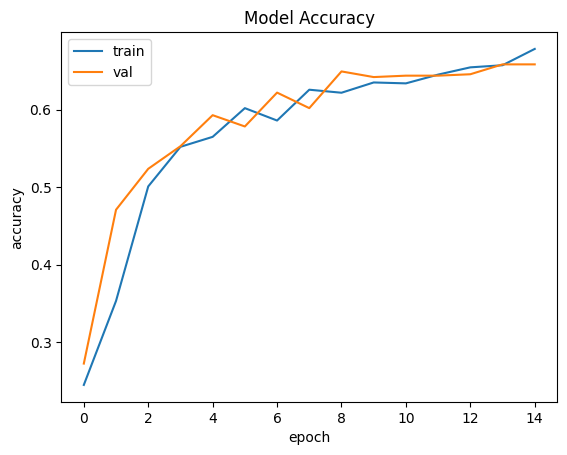

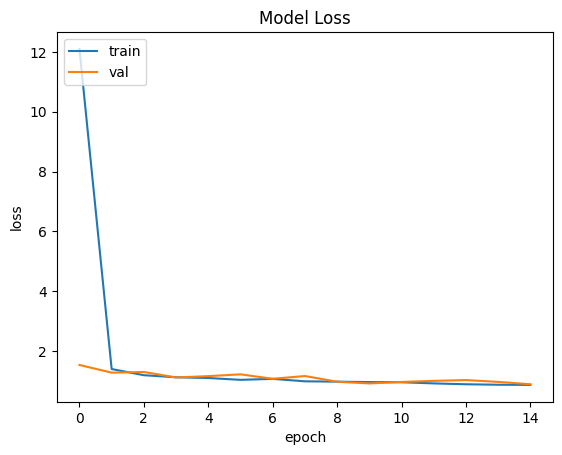

In [10]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Now, we evaluate our model on the test set and display the accuracy and loss.

In [11]:
model_1 = keras.saving.load_model("model_1.keras")
val_loss, val_accuracy = model_1.evaluate(val_ds)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.9836 - sparse_categorical_accuracy: 0.6485
Validation Loss: 0.9666903614997864
Validation Accuracy: 0.6581818461418152


#### LEARNING RATE = 1e-4

Next, we create the same model but train it with `learning_rate=1e-4`.

In [13]:
model_2 = keras.Sequential()

model_2.add(keras.Input(shape=(180,180,3)))

model_2.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(units=5, activation="softmax"))

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 178, 178, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 89, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 87, 87, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 41, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │         103,685 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,101 (4.35 MB)

 Trainable params: 1,140,101 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model_2.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=["sparse_categorical_accuracy"])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "model_2.keras",
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
)

history = model_2.fit(train_ds, epochs=15, callbacks=[model_checkpoint_callback], validation_data=val_ds)

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 8.0515 - sparse_categorical_accuracy: 0.2659 - val_loss: 1.4724 - val_sparse_categorical_accuracy: 0.4491
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 1.4491 - sparse_categorical_accuracy: 0.4139 - val_loss: 1.3729 - val_sparse_categorical_accuracy: 0.4745
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 1.3426 - sparse_categorical_accuracy: 0.4612 - val_loss: 1.2700 - val_sparse_categorical_accuracy: 0.5436
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 1.2350 - sparse_categorical_accuracy: 0.5101 - val_loss: 1.2005 - val_sparse_categorical_accuracy: 0.5527
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - loss: 1.1656 - sparse_categorical_accuracy: 0.5311 - val_loss: 1.1507 - val_sparse_categorical_accuracy: 0.5600
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 1.1584 - sparse_categorical_accuracy: 0.5423 - val_loss: 1.1362 - val_sparse_categorical_accuracy: 0.5855
Epoch 7/15
41/41

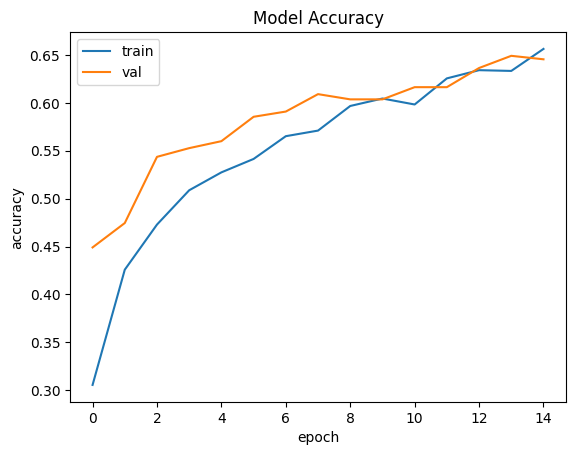

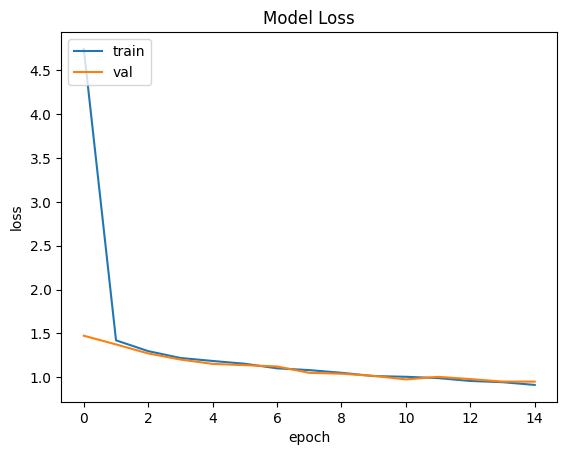

In [15]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
model_2 = keras.saving.load_model("model_2.keras")
val_loss, val_accuracy = model_2.evaluate(val_ds)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.9759 - sparse_categorical_accuracy: 0.6452
Validation Loss: 0.9489789605140686
Validation Accuracy: 0.6490908861160278


Learning rate of 1e-3 performs better than learning rate of 1e-4 on the validation set.

_Note: Additional learning rate values could be explored; however, we did not pursue this due to limited computational resources_

It is common practice to decrease the learning rate during training to help the model converge to its optimal minima. This can be done using a learning rate scheduler, which modifies the learning rate when the validation loss or metrics stop improving. In Keras, this can be achieved using the `ReduceLROnPlateau` callback.

Now, let's train our final model for 40 epochs with an initial learning rate of 1e-3. We'll utilize `ReduceLROnPlateau` and `ModelCheckpoint` callbacks to modify the learning rate and save the model with the highest validation accuracy.

In [ ]:
model = keras.Sequential()

model.add(keras.Input(shape=(180,180,3)))

model.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units=5, activation="softmax"))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 178, 178, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 89, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 87, 87, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 41, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 20, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │         103,685 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,101 (4.35 MB)

 Trainable params: 1,140,101 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "model.keras",
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=0.00001,
)

history = model.fit(train_ds, epochs=40, callbacks=[model_checkpoint_callback, reduce_lr], validation_data=val_ds)

Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 29.6583 - sparse_categorical_accuracy: 0.2691 - val_loss: 1.2694 - val_sparse_categorical_accuracy: 0.4564 - learning_rate: 0.0010
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 1.2959 - sparse_categorical_accuracy: 0.4309 - val_loss: 1.1635 - val_sparse_categorical_accuracy: 0.5109 - learning_rate: 0.0010
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 1.2206 - sparse_categorical_accuracy: 0.4916 - val_loss: 1.1123 - val_sparse_categorical_accuracy: 0.5764 - learning_rate: 0.0010
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 1.1375 - sparse_categorical_accuracy: 0.5502 - val_loss: 1.0882 - val_sparse_categorical_accuracy: 0.5891 - learning_rate: 0.0010
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 1.1060 - sparse_categorical_accuracy: 0.5472 - val_loss: 1.0786 - val_sparse_categorical_accuracy: 0.6218 - learning_rate: 0.0010
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - loss: 1

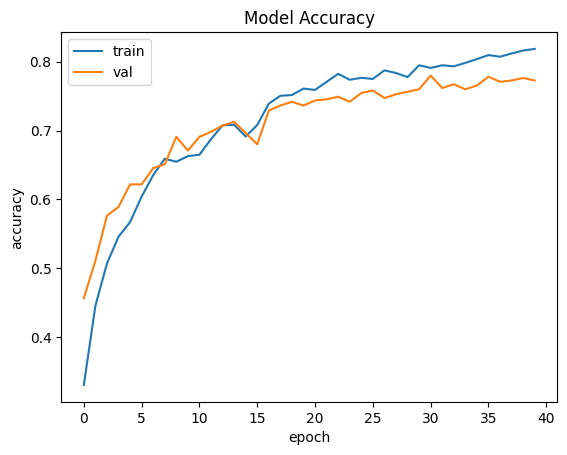

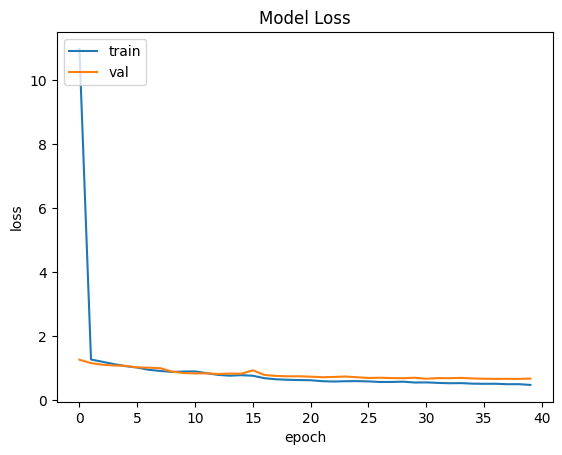

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model = keras.saving.load_model("model.keras")
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.5283 - sparse_categorical_accuracy: 0.8086
Test Loss: 0.4754926264286041
Test Accuracy: 0.8221415877342224


In this notebook, we completed our exploration of the `tf_flowers` dataset. Starting with a [baseline architecture](https://github.com/shaivimalik/cv/blob/main/base_architecture.ipynb), we enhanced our model through [data augmentation](https://github.com/shaivimalik/cv/blob/main/data_augmentation.ipynb) to learn more generalizable features. We then optimized the model's performance by fine-tuning hyperparameters. In the upcoming notebooks, we will explore more advanced computer vision tasks using Keras.